In [1]:
import stability_functions as sf
import numpy as np
from numpy.random import normal, seed, uniform
import os
import time
import sys
import rebound
import mr_forecast as mr
import numpy.random as rd
import radvel
import corner
import copy
import scipy
import pandas as pd
from scipy import optimize
from radvel.plot import orbit_plots
import random
import dill
import sys
sys.path.append("../spock")
from spock import StabilityClassifier
import dask.dataframe as dd
from celmech import Andoyer
from multiprocessing import Pool
# plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
plt.style.use('paper.mplstyle')
cmaprb = mcol.LinearSegmentedColormap.from_list("MyCmapName",["r","b"])
# %matplotlib inline

/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/radvel/gp.py:33: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  Try installing celerite using 'pip install celerite'", ImportWarning)


# Generating systems and scores

In [4]:
sim_names = "K431/K431_uni_dens"
use_log_e = False
n = 10000
n_workers = 4  # ?

In [5]:
def init_process():
    global model
    model = StabilityClassifier()
    
def pred(nsim):
    sim = rebound.SimulationArchive(sim_names + "_sa_%d.bin"%nsim)[0]
    sim.move_to_com()
    sim.integrator="whfast"
    sim.dt = 0.07*sim.particles[1].P
#     prob=model.predict(sim)
    prob=model.predict(sim, copy=False)
    return prob

def get_k(row):
    sim = rebound.SimulationArchive(sim_names + "_sa_%d.bin"%(row[0]))[0]
#     print(sim)
    p2 = sim.particles[2]
    row['h'] = p2.e*np.sin(p2.pomega)
    row['k'] = p2.e*np.cos(p2.pomega)
    avars = Andoyer.from_Simulation(sim, a10=sim.particles[1].a, j=5, k=1, i1=1, i2=2, average=False)
    row['Z12'] = avars.Z
    row['Zcom12'] = avars.Zcom
    avars = Andoyer.from_Simulation(sim, a10=sim.particles[1].a, j=4, k=1, i1=2, i2=3, average=False)
    row['Z23'] = avars.Z
    row['Zcom23'] = avars.Zcom
    row['e1'] = sim.particles[1].e
    row['e2'] = sim.particles[2].e
    row['e3'] = sim.particles[3].e
    row['m1'] = sim.particles[1].m
    row['m2'] = sim.particles[2].m
    row['m3'] = sim.particles[3].m
    return row

pool = Pool(processes=n_workers, initializer=init_process)

/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. Th

In [6]:
%%time
log_min_e = np.ones(3) * np.log(1e-3)

# getting basic r-m scaling laws from https://www.saraseager.com/research/exoplanet-interior-composition/
h_exp = (np.log(10) - np.log(1)) / (np.log(5.96) - np.log(3.05))
fe_exp = (np.log(10) - np.log(1)) / (np.log(1.4) - np.log(0.7))

for i in range(n):
    name = sim_names + "_sa_%d.bin"%i
    Ps = np.array([sf.a_normal(6.80252171, 7.931e-05, 7.931e-05), sf.a_normal(8.70337044, 9.645e-05, 9.645e-05), sf.a_normal(11.9216214, 0.0001182, 0.0001182)]) / sf.days_p_year
    As = Ps ** (2./3)
    es = np.array([0,0,0])
    bad_es = True
    e0_max = sf.max_e_inner(As[0], As[1])
    e1_max = np.minimum(sf.max_e_inner(As[1], As[2], es[2]), sf.max_e_outer(As[1], As[0]))  # ~0.15
    e2_max = sf.max_e_outer(As[2], As[1])
    while bad_es:
        es = np.exp(rd.rand(3) * (np.log([e0_max, e1_max, e2_max]) - log_min_e) + log_min_e)
        if use_log_e:
            es = np.exp(rd.rand(3) * (np.log([e0_max, e1_max, e2_max]) - log_min_e) + log_min_e)
        else:
            es =rd.rand(3) * np.array([e0_max, e1_max, e2_max])
        bad_es = not sf.check_es(As[0], es[0], As[1], es[1], As[2], es[2])
    rs = np.array([sf.a_normal(1.088, 0.146, 0.146), sf.a_normal(1.072, 0.171, 0.171), sf.a_normal(1.307, 0.160, 0.160)])
    lower = np.exp((np.log(rs) - np.log(3.05)) * h_exp)
    upper = np.exp((np.log(rs) - np.log(0.7)) * fe_exp)
    ms = lower + rd.rand(3) * (upper - lower)
    sim = sf.build_chosen_K431(ms, es, Ps)
    sf.replace_snapshot(sim, name)

CPU times: user 9.08 s, sys: 4.27 s, total: 13.3 s
Wall time: 2min 49s


In [139]:
%%time
nsim_list = np.arange(0,n)
res = pool.map(pred, nsim_list)

/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. Th

KeyboardInterrupt: 

  File "/storage/home/cjg66/miniconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/storage/home/cjg66/miniconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/storage/home/cjg66/miniconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [140]:
%%time
df1 = pd.DataFrame(nsim_list, columns=['sim'])
df1['k'] = 0.
df1['h'] = 0.
df1['Z12'] = 0.
df1['Zcom12'] = 0.
df1['Z23'] = 0.
df1['Zcom23'] = 0.
df1['e1'] = 0.
df1['e2'] = 0.
df1['e3'] = 0.
df1['m1'] = 0.
df1['m2'] = 0.
df1['m3'] = 0.
df1['probstability'] = res

dasklabels = dd.from_pandas(df1, npartitions=n_workers)
df = dasklabels.apply(get_k, axis=1, meta=df1).compute(scheduler='processes')

df.to_csv("K431_uni_dens.csv")

/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


ValueError: Length of values does not match length of index

# Corner plots

In [25]:
df = pd.read_csv("K431_uni_dens.csv")
df["m1"] /= sf.earth_mass_2_solar_mass
df["m2"] /= sf.earth_mass_2_solar_mass
df["m3"] /= sf.earth_mass_2_solar_mass
df["m1+m2"] = df["m1"] + df["m2"]
df["m2+m3"] = df["m2"] + df["m3"]
df["total m"] = df["m1"] + df["m2"] + df["m3"]
scores = 2 * df["probstability"]
n = len(scores)
# effective sample size using eq 9.13 https://statweb.stanford.edu/~owen/mc/Ch-var-is.pdf
effective_sample_size = n * np.mean(scores) ** 2 / np.mean(scores ** 2)
print(effective_sample_size)
print(n)
print(effective_sample_size / n)

806.8470104677044
10000
0.08068470104677045


In [26]:
def quantile_1D(data, weights, quantile):
    ind_sorted = np.argsort(data)
    sorted_data = data[ind_sorted]
    sorted_weights = weights[ind_sorted]
    Sn =  np.array(np.cumsum(sorted_weights))
    Pn = (Sn-0.5*sorted_weights)/Sn[-1]
    return np.interp(quantile, Pn, sorted_data)

In [27]:
notebook_name = "K431_density_"
system_name = "K431 "

def create_hist(label, show_quantiles=True, label2="", xlabel=""):
    if label2 == "":
        label2=label
    plt.figure(figsize=(8,4.5))
    n_bins=50
    plt.hist(df[label], density=True, bins=n_bins, alpha=0.6)
    plt.hist(df[label], density=True, bins=n_bins, alpha=0.6, weights=df["probstability"])
    # plt.hist(df[label], n_bins, density=True, histtype='step', cumulative=True)
    # plt.hist(df[label], n_bins, density=True, histtype='step', cumulative=True, weights=df["probstability"])
    plt.title(system_name + label2, size=30)
    plt.xlabel(xlabel, size=20)
    if show_quantiles:
        quant1 = np.quantile(df[label], 0.16)
        quant2 = np.quantile(df[label], 0.84)
        plt.axvline(x=quant1, color="C0")
        plt.axvline(x=quant2, color="C0")
        quant3 = quantile_1D(df[label], df["probstability"], 0.16)
        quant4 = quantile_1D(df[label], df["probstability"], 0.84)
        plt.axvline(x=quant3, color="C1")
        plt.axvline(x=quant4, color="C1")
        sigma1 = (quant2 - quant1) / 2
        sigma2 = (quant4 - quant3) / 2
        print("\"sigma\" before: %f"%(sigma1))
        print("\"sigma\" after: %f"%(sigma2))
        print("factor of %f smaller"%(sigma1/sigma2))
    plt.savefig(notebook_name + label + "_hist.png", bbox_inches="tight")

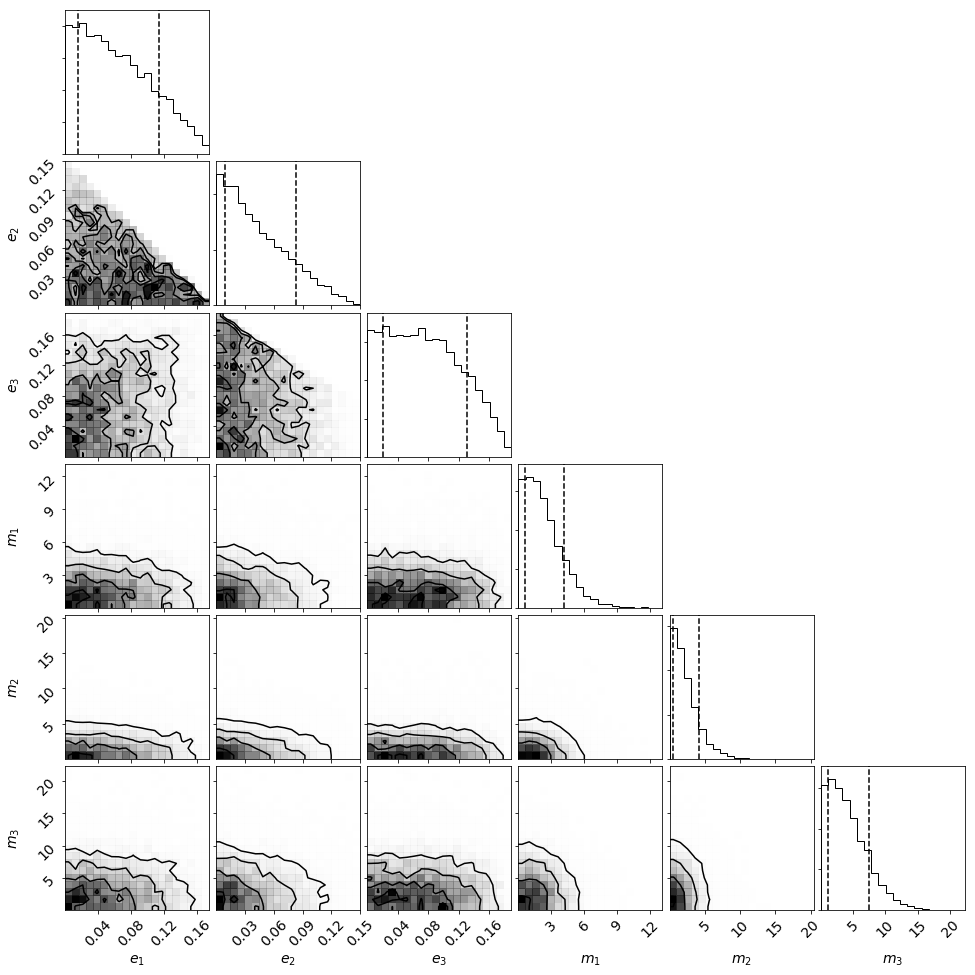

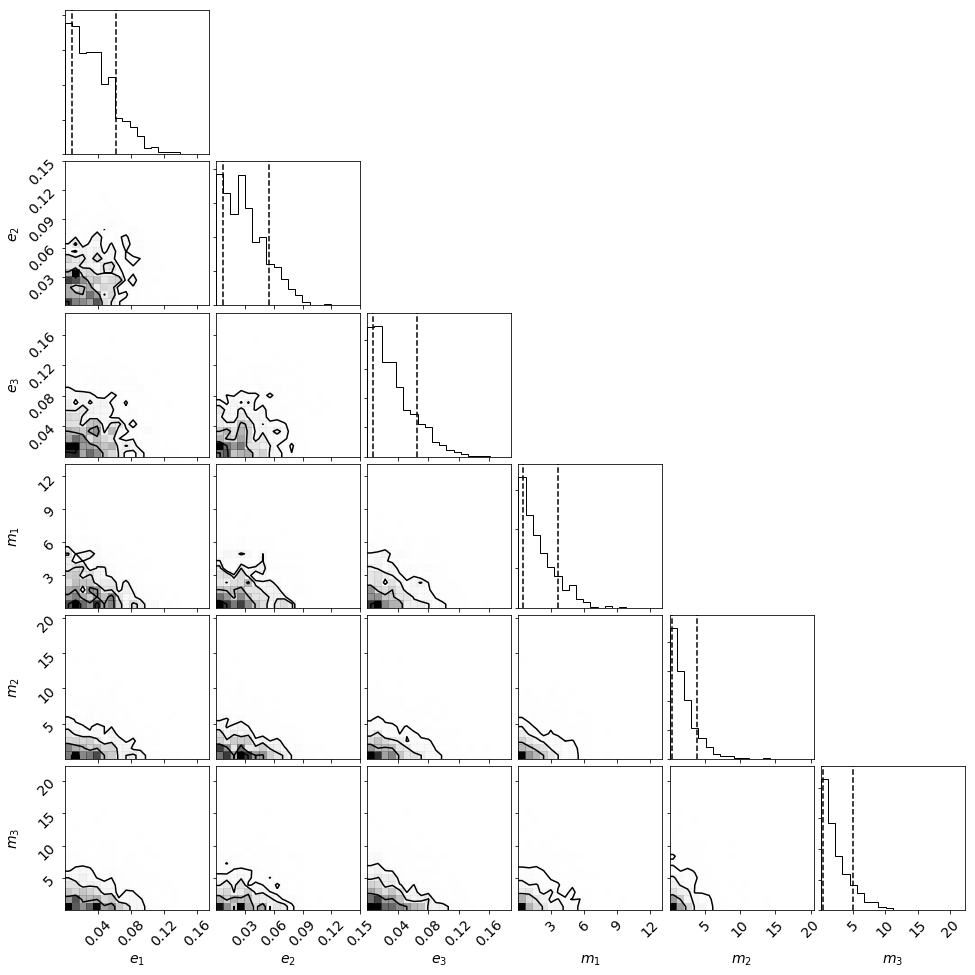

In [5]:
labels = ["e1","e2", "e3", "m1", "m2", "m3"]
labels2 = [r"$e_1$", r"$e_2$", r"$e_3$", r"$m_1$", r"$m_2$", r"$m_3$"]
fig = corner.corner(df[labels], labels=labels2, quantiles=[0.15,0.85], plot_datapoints=False)
plt.savefig(notebook_name + "physical_corner_noweight.png", bbox_inches="tight")
fig = corner.corner(df[labels], labels=labels2, quantiles=[0.15,0.85], plot_datapoints=False, weights=df["probstability"])
plt.savefig(notebook_name + "physical_corner_weight.png", bbox_inches="tight")

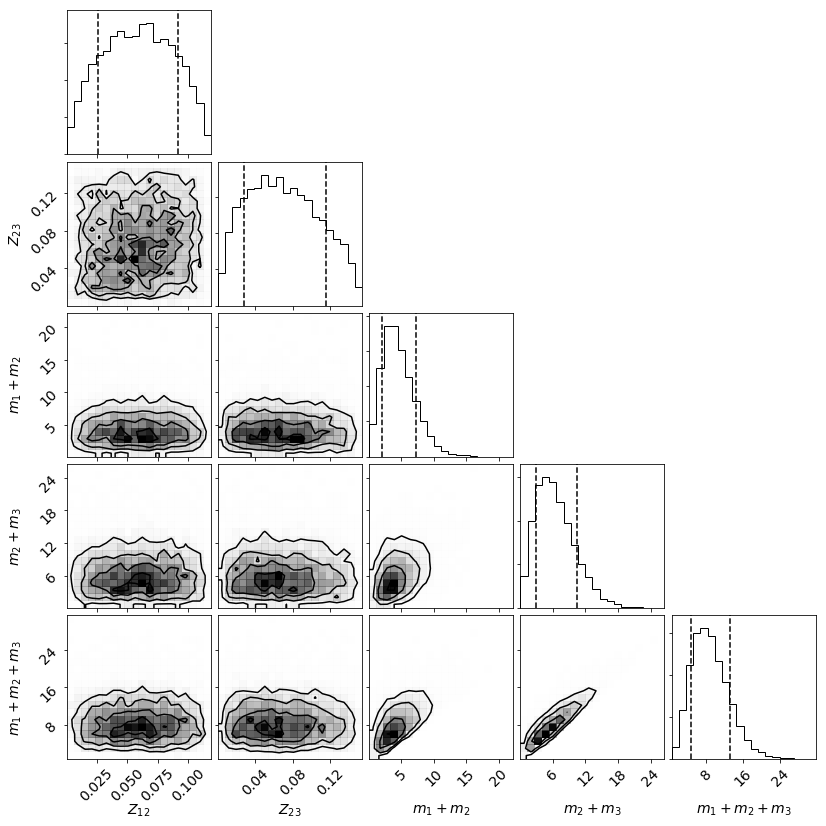

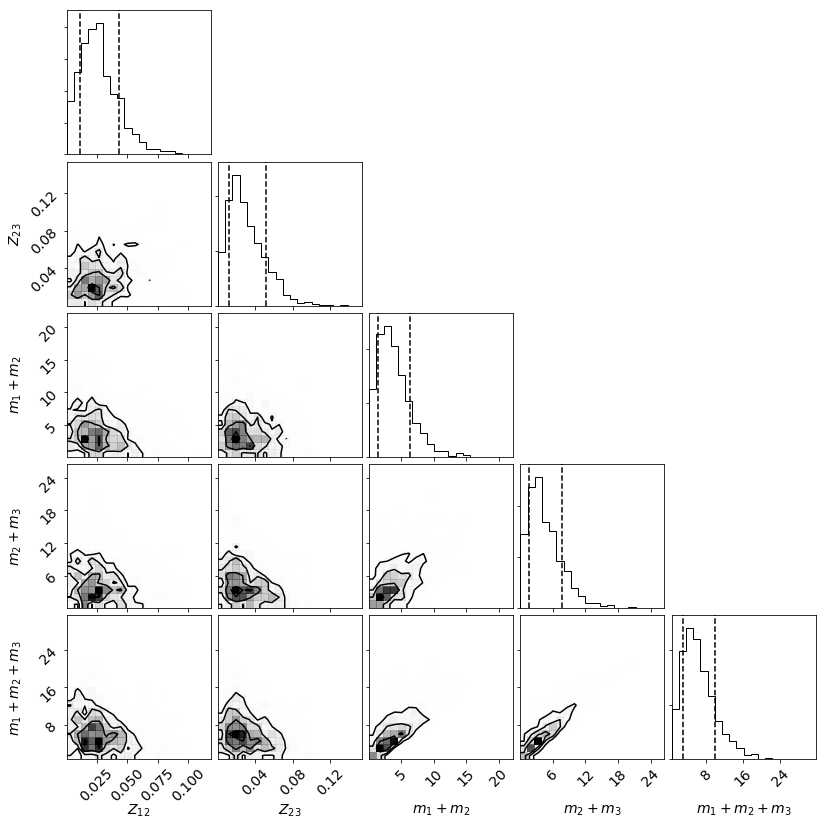

In [6]:
labels = ["Z12", "Z23", "m1+m2", "m2+m3", "total m"]
labels2 = [r"$Z_{12}$", r"$Z_{23}$", r"$m_1 + m_2$", r"$m_2 + m_3$", r"$m_1 + m_2 + m_3$"]
fig = corner.corner(df[labels], labels=labels2, quantiles=[0.15,0.85], plot_datapoints=False)
plt.savefig(notebook_name + "param_corner_noweight.png", bbox_inches="tight")
fig = corner.corner(df[labels], labels=labels2, quantiles=[0.15,0.85], plot_datapoints=False, weights=df["probstability"])
plt.savefig(notebook_name + "param_corner_weight.png", bbox_inches="tight")

"sigma" before: 1.699540
"sigma" after: 1.536579
factor of 1.106054 smaller
"sigma" before: 1.719318
"sigma" after: 1.687904
factor of 1.018611 smaller
"sigma" before: 3.065462
"sigma" after: 2.104695
factor of 1.456488 smaller


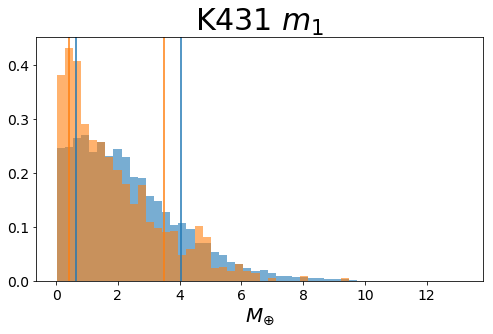

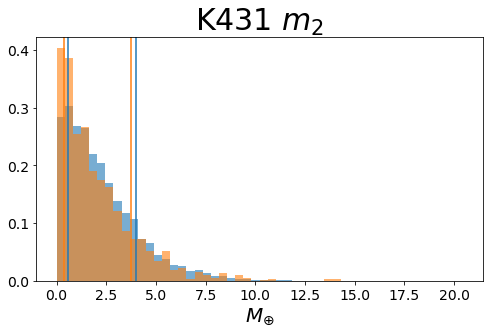

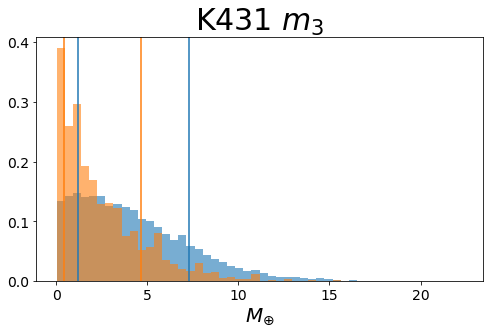

In [7]:
create_hist("m1", label2=r"$m_1$", xlabel=r"$M_{\oplus}$")
create_hist("m2", label2=r"$m_2$", xlabel=r"$M_{\oplus}$")
create_hist("m3", label2=r"$m_3$", xlabel=r"$M_{\oplus}$")

"sigma" before: 2.476197
"sigma" after: 2.391890
factor of 1.035247 smaller
"sigma" before: 3.615109
"sigma" after: 2.899119
factor of 1.246968 smaller
"sigma" before: 3.999332
"sigma" after: 3.363178
factor of 1.189153 smaller


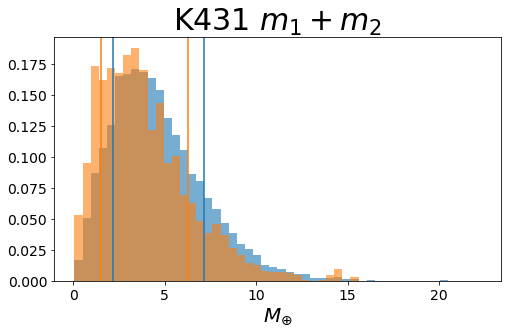

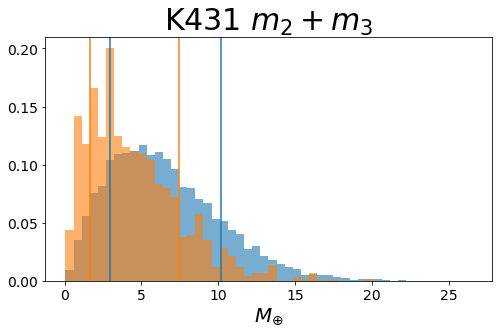

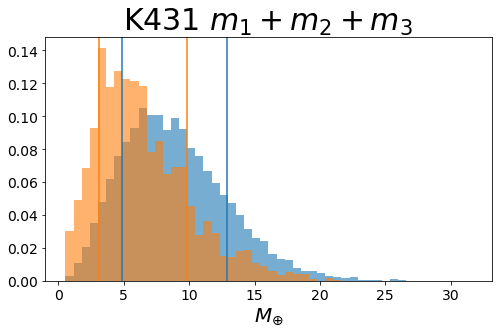

In [8]:
create_hist("m1+m2", label2=r"$m_1 + m_2$", xlabel=r"$M_{\oplus}$")
create_hist("m2+m3", label2=r"$m_2 + m_3$", xlabel=r"$M_{\oplus}$")
create_hist("total m", label2=r"$m_1 + m_2 + m_3$", xlabel=r"$M_{\oplus}$")

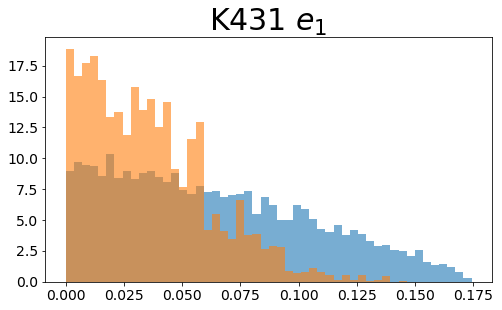

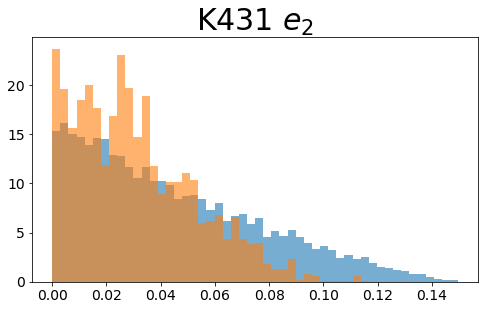

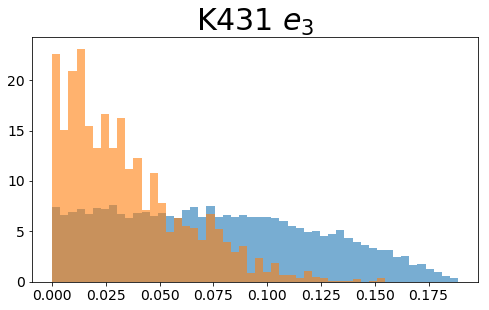

In [9]:
create_hist("e1", show_quantiles=False, label2=r"$e_1$")
create_hist("e2", show_quantiles=False, label2=r"$e_2$")
create_hist("e3", show_quantiles=False, label2=r"$e_3$")

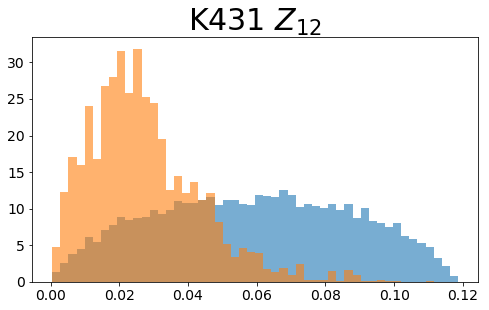

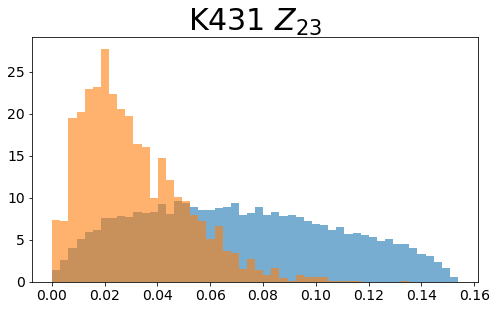

In [10]:
create_hist("Z12", show_quantiles=False, label2=r"$Z_{12}$")
create_hist("Z23", show_quantiles=False, label2=r"$Z_{23}$")

# RV constraints

In [30]:
seconds_p_day = 86400
days_p_year = 365.25
meters_p_AU = 149597870700
earth_mass_2_solar_mass = 0.000003003
year_p_reboundtime = 1 / (2 * np.pi)

# Convenient function for plotting fits
def plot_results(like):
    ti = np.linspace(np.min(t), np.max(t), 1000)
    fig = plt.gcf()
    plt.errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    plt.plot(ti, like.model(ti))
    plt.xlabel('Time')
    plt.ylabel('RV')
    plt.draw()

In [31]:
sim_nums = np.array([10, 82, 199, 55, 101, 84, 127, 2050, 261, 100, 190, 218])
sim_num = sim_nums[0]

system = "K431"
out_dir = os.getcwd()+"/output/"+system+"/"
name = out_dir+system+"_start_"+str(sim_num)+".bin"

print("simulation archive:", name)
sim = rebound.SimulationArchive(name)[0]

simulation archive: /storage/work/c/cjg66/Dan_research/Stability-Priors/output/K431/K431_start_10.bin


In [60]:
seed(3)
n_meas = 50
t = 0.5 * np.sort(rd.rand(n_meas))
syn_rv = sf.rebound_rvs(t, rebound.SimulationArchive(name)[0])
t *= days_p_year

errs = np.array([10, 3, 1, 0.3, 0.1, 0.03, 0.01])
if sys.argv[1] != "-f":
    err_ind = int(sys.argv[1])
else:
    err_ind = 1
errvel = errs[err_ind]

jitter = 0.0
stellar = jitter * rd.randn(n_meas)

syn_rv += rd.randn(n_meas) * errvel + stellar
print("jitter value:", jitter)

jitter value: 0.0


In [61]:
Ps = np.array([sim.particles[i+1].P for i in range(3)]) * (days_p_year * year_p_reboundtime)
es = np.array([sim.particles[i+1].e for i in range(3)])
Mstar = sim.particles[0].m
ms = np.array([sim.particles[i+1].m for i in range(3)]) / earth_mass_2_solar_mass
incs = np.array([sim.particles[i+1].inc for i in range(3)]) + np.pi/2
og_Ks = sf.VSA(Ps / days_p_year, Mstar, ms, es, incs)
Ks = np.copy(og_Ks)

# omegas = np.pi * 2 * np.random.uniform(size=3)
omegas = np.array([sim.particles[i+1].omega for i in range(3)])
print("og Ks:", og_Ks)
print("initial Ks:", Ks)

og Ks: [0.29795106 0.47920105 1.04729092]
initial Ks: [0.29795106 0.47920105 1.04729092]


In [62]:
params = radvel.Parameters(3, basis='per tc secosw sesinw k')
params['per1'] = radvel.Parameter(value=Ps[0])
params['tc1'] = radvel.Parameter(value= 2454971.03562)
params['secosw1'] = radvel.Parameter(value=np.sqrt(es[0]) * np.cos(omegas[0]))
params['sesinw1'] = radvel.Parameter(value=np.sqrt(es[0]) * np.sin(omegas[0]))
params['k1'] = radvel.Parameter(value=Ks[0])

params['per2'] = radvel.Parameter(value=Ps[1])
params['tc2'] = radvel.Parameter(value=2454973.1707)
params['secosw2'] = radvel.Parameter(value=np.sqrt(es[1]) * np.cos(omegas[1]))
params['sesinw2'] = radvel.Parameter(value=np.sqrt(es[1]) * np.sin(omegas[1]))
params['k2'] = radvel.Parameter(value=Ks[1])

params['per3'] = radvel.Parameter(value=Ps[2])
params['tc3'] = radvel.Parameter(value=2454970.47509)
params['secosw3'] = radvel.Parameter(value=np.sqrt(es[2]) * np.cos(omegas[2]))
params['sesinw3'] = radvel.Parameter(value=np.sqrt(es[2]) * np.sin(omegas[2]))
params['k3'] = radvel.Parameter(value=Ks[2])

# params['dvdt'] = radvel.Parameter(value=0)
# params['curv'] = radvel.Parameter(value=0)

rv_mod = radvel.RVModel(params)

In [63]:
like_syn = radvel.likelihood.RVLikelihood(rv_mod, t, syn_rv, np.zeros(t.size)+errvel)
like_syn.params['gamma'] = radvel.Parameter(value=0)
like_syn.params['jit'] = radvel.Parameter(value=jitter)

like_syn.params['jit'].vary = False # Don't vary jitter
# like_syn.params['k1'].vary = False # Don't vary period
# like_syn.params['k2'].vary = False # Don't vary period
# like_syn.params['k3'].vary = False # Don't vary period
# like_syn.params['per1'].vary = False # Don't vary period
# like_syn.params['per2'].vary = False # Don't vary period
# like_syn.params['per3'].vary = False # Don't vary period
like_syn.params['dvdt'].vary = False # Don't vary dvdt
like_syn.params['curv'].vary = False # Don't vary curvature
like_syn.params['gamma'].vary = False # Don't vary gamma
print(like_syn)

parameter                     value      vary
per1                        6.80249       True
tc1                         4971.04       True
secosw1                   -0.110573       True
sesinw1                  -0.0103887       True
k1                         0.297951       True
per2                        8.70325       True
tc2                         4973.17       True
secosw2                  -0.0882106       True
sesinw2                   0.0495855       True
k2                         0.479201       True
per3                        11.9216       True
tc3                         4970.48       True
secosw3                   0.0262267       True
sesinw3                  -0.0580268       True
k3                          1.04729       True
dvdt                              0      False
curv                              0      False
gamma                             0      False
jit                               0      False



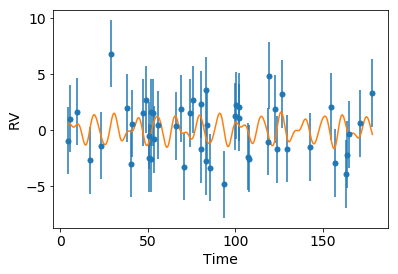

In [64]:
# Plot initial model
plot_results(like_syn)
# plt.savefig("figs/beforeMLE_%d.png"%err_ind, bbox_inches="tight")
# plt.close(fig="all")

parameter                     value      vary
per1                        6.80297       True
tc1                         4971.04       True
secosw1                   -0.110573       True
sesinw1                  -0.0103887       True
k1                         0.297951       True
per2                        8.70281       True
tc2                         4973.17       True
secosw2                  -0.0882106       True
sesinw2                   0.0495855       True
k2                         0.479201       True
per3                        11.9219       True
tc3                         4970.48       True
secosw3                   0.0262267       True
sesinw3                  -0.0580268       True
k3                          1.04729       True
dvdt                              0      False
curv                              0      False
gamma                             0      False
jit                               0      False



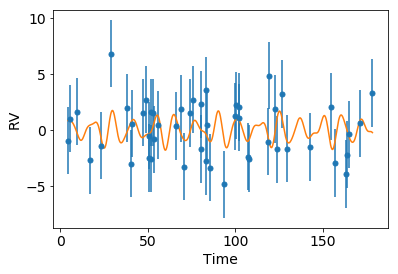

In [65]:
res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='L-BFGS-B')
# print(res)
print(like_syn)
plot_results(like_syn) # plot best fit model
# plt.savefig("figs/afterMLE_%d.png"%err_ind, bbox_inches="tight")

In [66]:
post = radvel.posterior.Posterior(like_syn)

# post.priors += [radvel.prior.EccentricityPrior([1], [0.1])]
# post.priors += [radvel.prior.EccentricityPrior([2], [0.1])]
# post.priors += [radvel.prior.EccentricityPrior([3], [0.28])]
# post.priors += [radvel.prior.EccentricityPrior(3, 0.3)]

post.priors += [radvel.prior.Gaussian("per1", 6.80252171, 7.931e-05)]
post.priors += [radvel.prior.Gaussian("per2", 8.70337044, 9.645e-05)]
post.priors += [radvel.prior.Gaussian("per3", 11.9216214, 0.0001182)]

labels = [k for k in post.params.keys() if post.params[k].vary]

print("Before fitting\n")
print(post)

Before fitting

parameter                     value      vary
per1                        6.80297       True
tc1                         4971.04       True
secosw1                   -0.110573       True
sesinw1                  -0.0103887       True
k1                         0.297951       True
per2                        8.70281       True
tc2                         4973.17       True
secosw2                  -0.0882106       True
sesinw2                   0.0495855       True
k2                         0.479201       True
per3                        11.9219       True
tc3                         4970.48       True
secosw3                   0.0262267       True
sesinw3                  -0.0580268       True
k3                          1.04729       True
dvdt                              0      False
curv                              0      False
gamma                             0      False
jit                               0      False

Priors
------
Gaussian prior on per1, mu=6.8

In [67]:
# res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='Nelder-Mead' )
res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='L-BFGS-B')
# plot_results(post.likelihood)
# plt.savefig("afterpriors_%d.png"%err_ind, bbox_inches="tight")
print("After fitting\n")
print(post)

After fitting

parameter                     value      vary
per1                        6.80256       True
tc1                         4971.04       True
secosw1                   -0.110573       True
sesinw1                  -0.0103887       True
k1                         0.297951       True
per2                        8.70327       True
tc2                         4973.17       True
secosw2                  -0.0882106       True
sesinw2                   0.0495855       True
k2                         0.479201       True
per3                        11.9217       True
tc3                         4970.48       True
secosw3                   0.0262267       True
sesinw3                  -0.0580268       True
k3                          1.04729       True
dvdt                              0      False
curv                              0      False
gamma                             0      False
jit                               0      False

Priors
------
Gaussian prior on per1, mu=6.80

No handles with labels found to put in legend.


(<Figure size 540x1018.29 with 6 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f9aaf248690>])

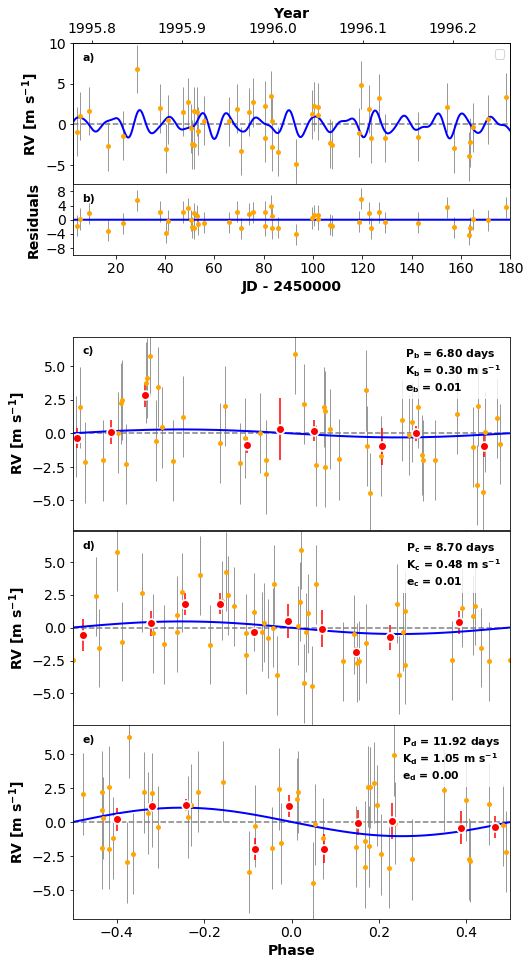

In [68]:
RVPlot = orbit_plots.MultipanelPlot(post)
RVPlot.plot_multipanel()
# plt.show()
# plt.savefig("figs/afterpriors_%d.png"%err_ind, bbox_inches="tight")
# plt.close(fig="all")

In [69]:
# df = radvel.mcmc(post) # amount of steps = nrun * 8 * nwalkers ?
df3 = radvel.mcmc(post, nrun=1000) # amount of steps = nrun * 8 * nwalkers ?, default nrun is 10000, default nwalkers is 50?
# df.to_pickle("mcmc/mcmc_K431_%d.pkl"%err_ind)

20000/400000 (5.0%) steps complete; Running 11517.95 steps/s; Mean acceptance rate = 31.4%; Min Tz = 2330.6; Max G-R = 1.012      
Discarding burn-in now that the chains are marginally well-mixed

140000/400000 (35.0%) steps complete; Running 14845.75 steps/s; Mean acceptance rate = 17.3%; Min Tz = 8254.1; Max G-R = 1.003      
Chains are well-mixed after 140000 steps! MCMC completed in 10.6 seconds




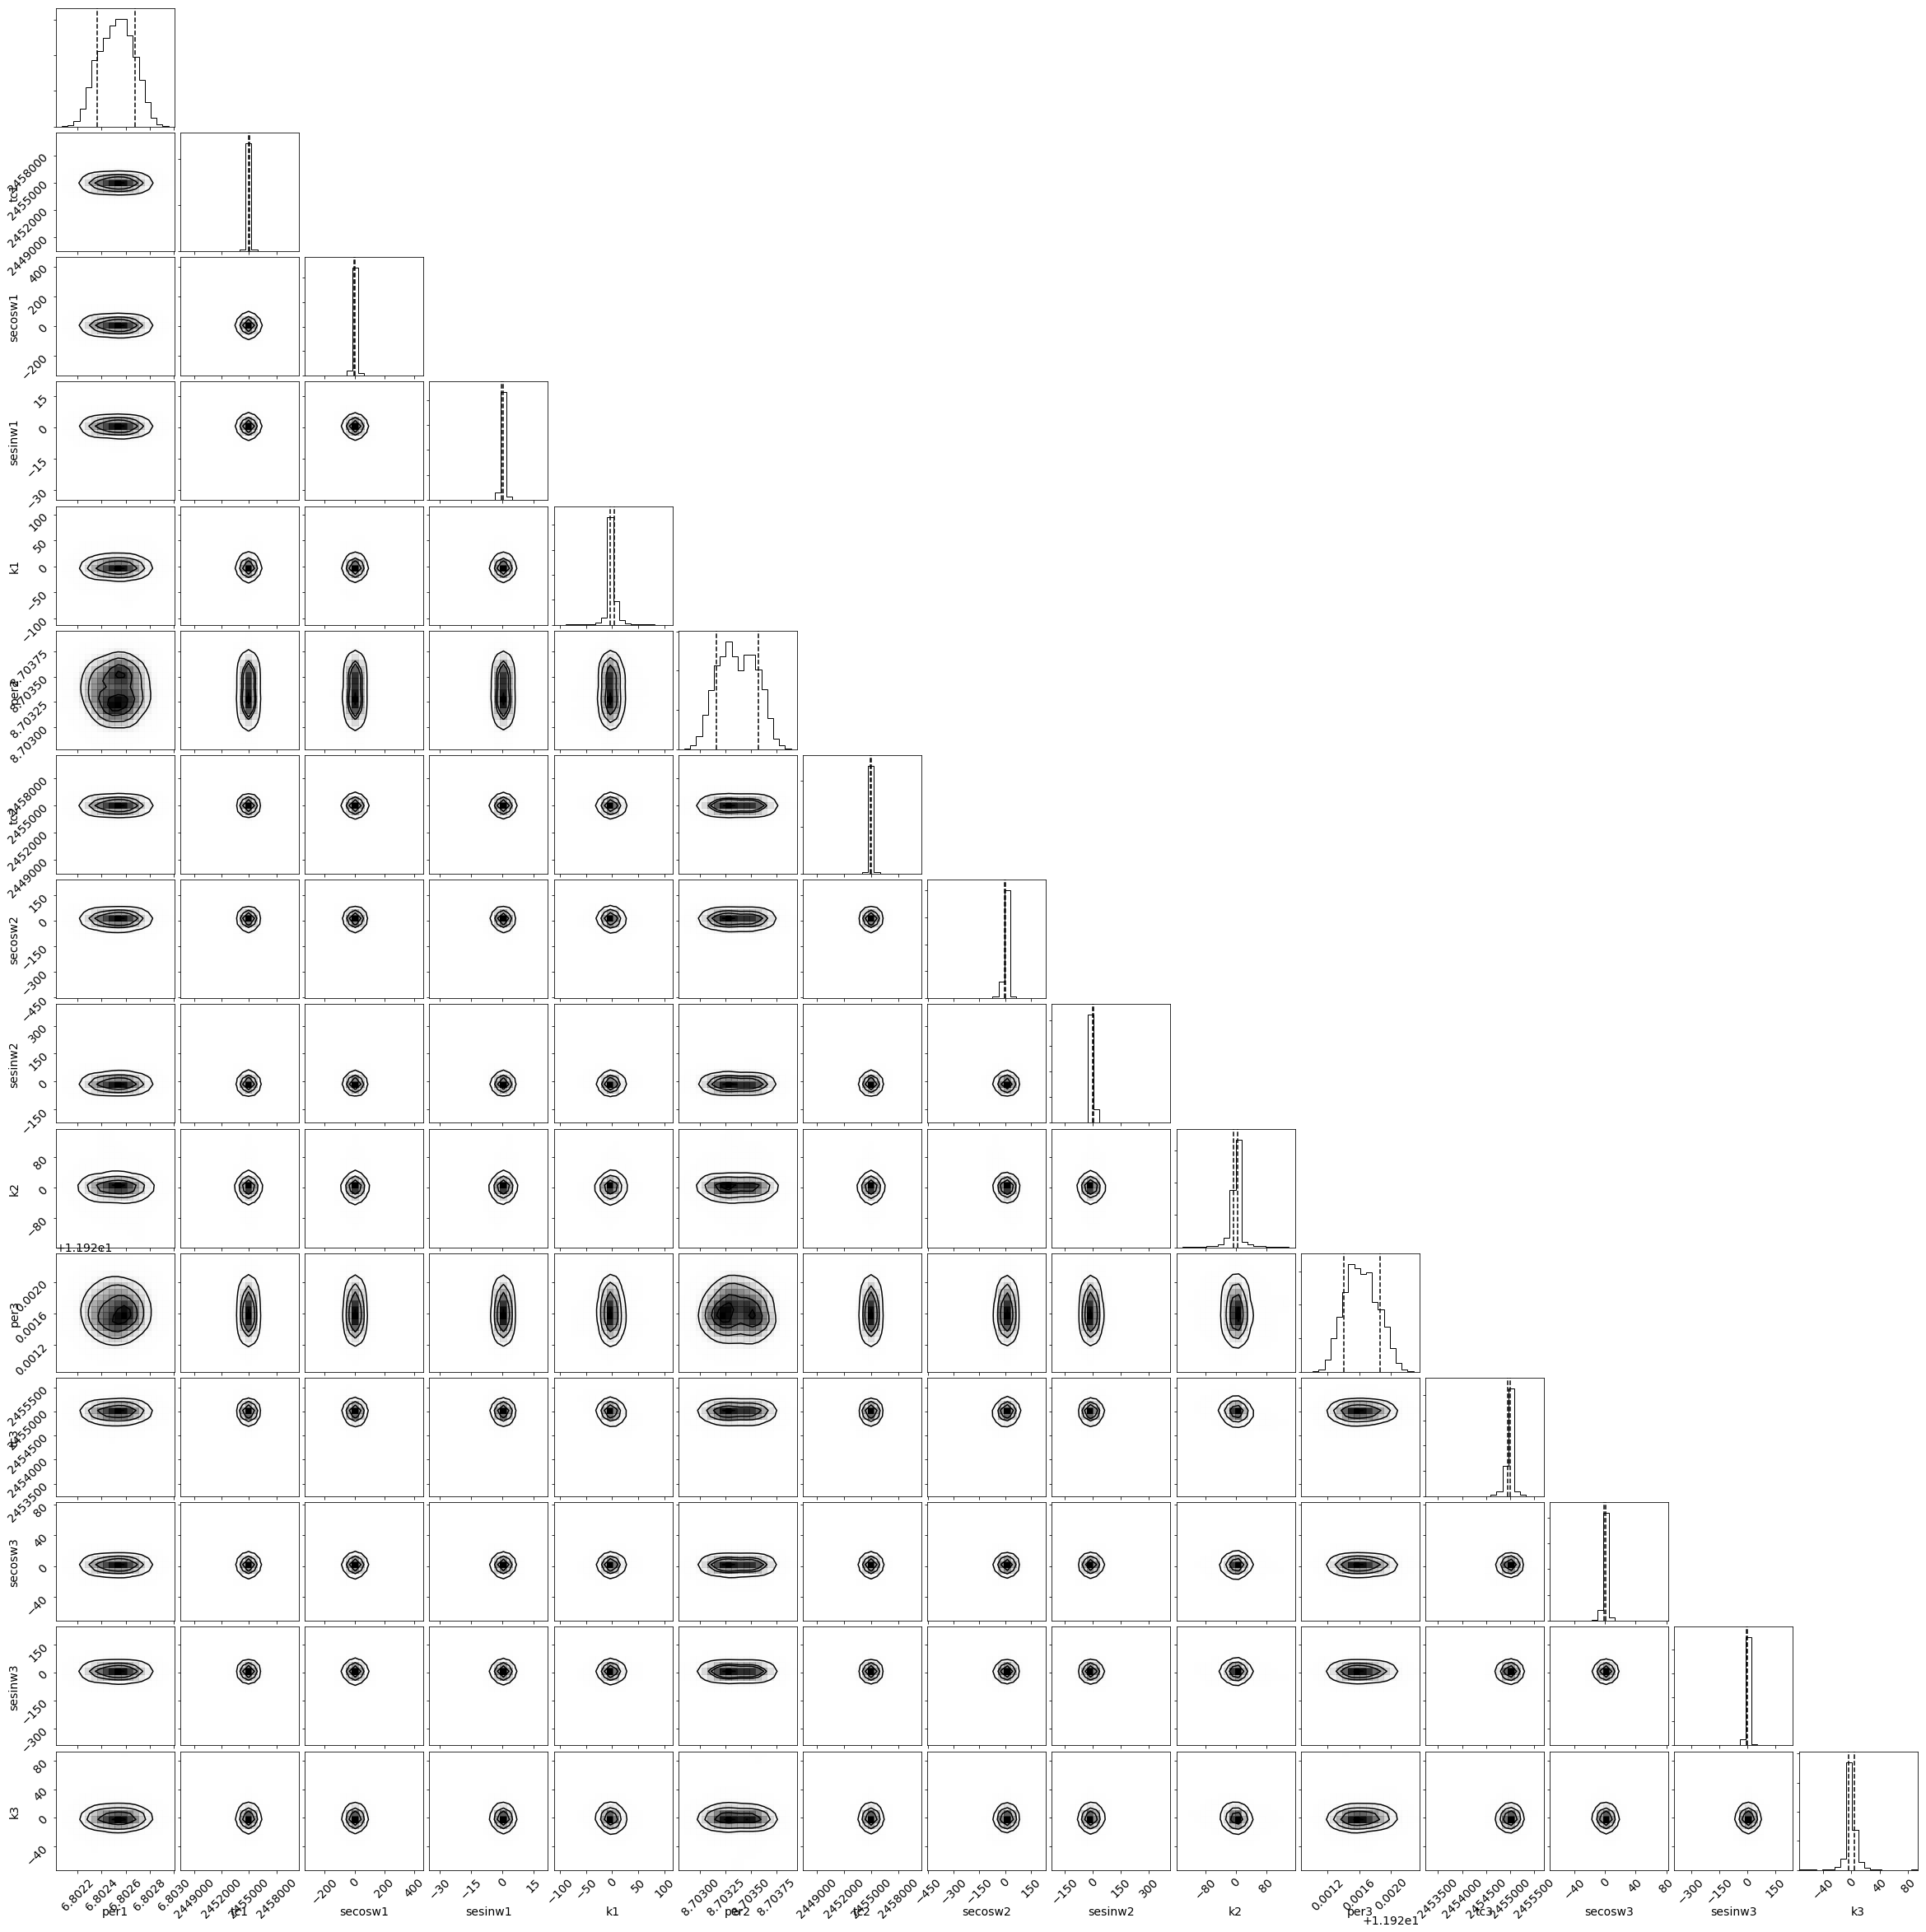

In [70]:
niter = len(df3)
labels = [k for k in post.params.keys() if post.params[k].vary]

fig = corner.corner(
    df3[labels],
    labels=labels,
    quantiles=[0.15,0.85],
    plot_datapoints=False,
    smooth=True,
    bins=20
    )
# if use_stab:
#     plt.savefig("figs/corner_K431_stab_%d.png"%err_ind, bbox_inches="tight")
# else:
#     plt.savefig("figs/corner_K431_%d.png"%err_ind, bbox_inches="tight")

simulation archive: /storage/work/c/cjg66/Dan_research/Stability-Priors/output/K431/K431_start_10.bin
working on err_ind 1
                 e1            m1             e2            m2             e3  \
count  1.200000e+05  56211.000000  120000.000000  54284.000000  120000.000000   
mean   2.905740e+02      1.537906     307.854266      2.390689      95.945350   
std    3.360962e+03      1.254890    2702.799264      1.772556    1344.286736   
min    1.795622e-07      0.000090       0.000003      0.000183       0.000010   
25%    3.494698e-02      0.615534       0.039806      1.055096       0.026144   
50%    1.507057e+00      1.236281       1.955141      2.064559       1.510291   
75%    3.047481e+01      2.119056      47.009433      3.304234      16.813425   
max    2.151824e+05     13.372266  211204.036805     12.859546  158019.258692   

                 m3  
count  55001.000000  
mean       3.144810  
std        2.184511  
min        0.000406  
25%        1.345387  
50%        2.88

ValueError: supplied range of [nan, nan] is not finite

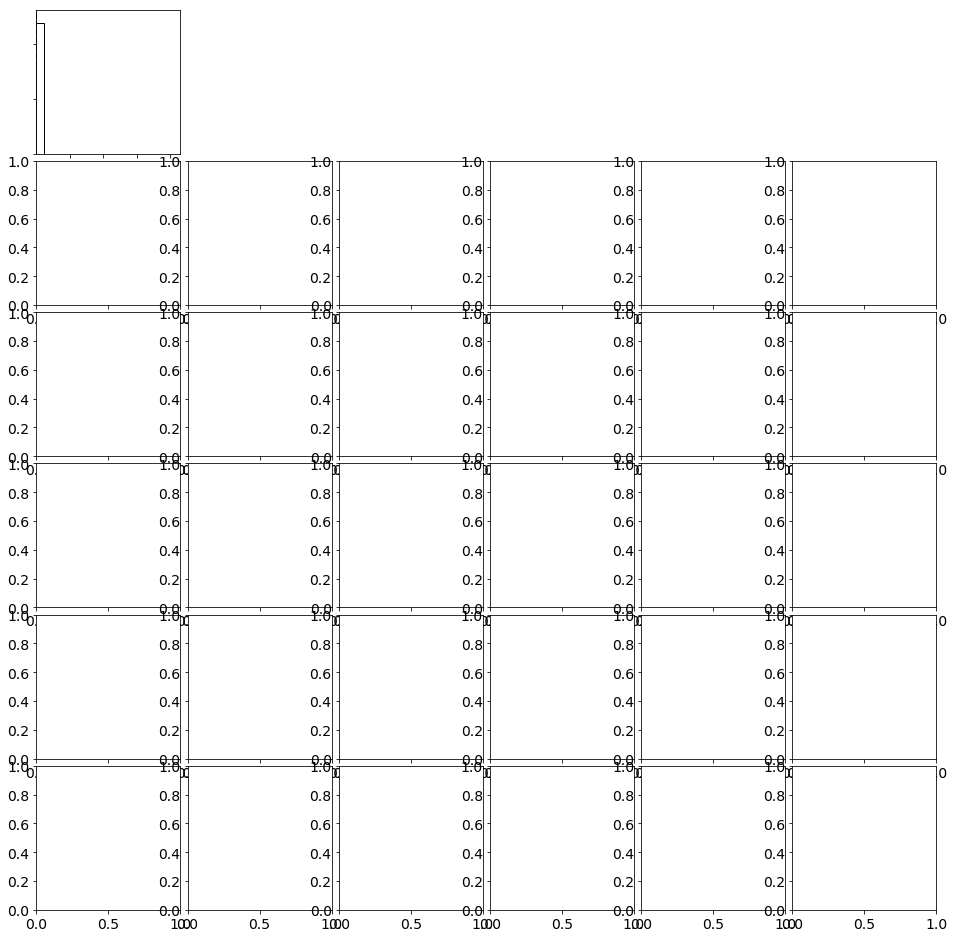

In [73]:
system = "K431"
out_dir = os.getcwd()+"/output/"+system+"/"
name = out_dir+system+"_start_"+str(sim_num)+".bin"

print("simulation archive:", name)
sim = rebound.SimulationArchive(name)[0]
# [].extend([sim.particles[i+1].e for i in range(3)])

# truths = []
# for i in range(3):
#     planet = sim.particles[i+1]
#     truths.append(sf.VSA(planet.P * sf.year_p_reboundtime, sim.particles[0].m, planet.m/sf.earth_mass_2_solar_mass, planet.e, planet.inc + np.pi/2))
truths = [sim.particles[i+1].e for i in range(3)]
truths2 = [sim.particles[i+1].m / earth_mass_2_solar_mass * np.cos(sim.particles[i+1].inc) for i in range(3)]

for index, item in enumerate(truths2):
    insert_index = index*2 + 1
    truths.insert(insert_index, item)

def prep_df(df2):
    df = df2.copy()
#     df = df.drop(columns="jit")
    df = df.drop(columns="lnprobability")
    for i in range(1,4):
        df["e%d"%i] = df["secosw%d"%i] ** 2 + df["sesinw%d"%i] ** 2
#         df["msini%d"%i] = sf.mass_from_VSA(df["per%d"%i] / days_p_year, Mstar, df["k%d"%i].abs(), df["e%d"%i], np.pi/2)
        df["m%d"%i] = sf.mass_from_VSA(df["per%d"%i] / days_p_year, Mstar, df["k%d"%i].abs(), df["e%d"%i], np.pi/2)
        df = df.drop(columns="k%d"%i)
        df = df.drop(columns="per%d"%i)
        df = df.drop(columns="tc%d"%i)
        df = df.drop(columns="secosw%d"%i)
        df = df.drop(columns="sesinw%d"%i)
#         df["k%d"%i] = 
    return df
    

print("working on err_ind %d"%err_ind)

df2 = prep_df(df3)
print(df2.describe())
labels = list(df2.columns)
fig = corner.corner(
    df2,
    labels=labels,
    truths=truths,
    quantiles=[0.15,0.85],
    plot_datapoints=False,
    smooth=True,
    bins=20.
    )
# plt.savefig("figs/corner_K431_%d_small.png"%err_ind, bbox_inches="tight")

In [81]:
i=1
e1 = df3["secosw%d"%i] ** 2 + df3["sesinw%d"%i] ** 2
print(len(df3["per%d"%i]), len(df3["k%d"%i].abs()), len(e1))
sf.mass_from_VSA(df3["per%d"%i] / days_p_year, Mstar, df3["k%d"%i].abs(), e1, np.pi/2)
e1

120000 120000 120000


0            0.030348
1            0.052822
2            0.013669
3            0.004245
4            0.104164
5            0.014280
6            0.004780
7            0.018777
8            0.030348
9            0.052822
10           0.012293
11           0.002396
12           0.104164
13           0.014280
14           0.006626
15           0.018777
16           0.030348
17           0.052822
18           0.012293
19           0.002396
20           0.104164
21           0.014280
22           0.010366
23           0.018777
24           0.030348
25           0.052822
26           0.011852
27           0.002640
28           0.104164
29           0.032874
             ...     
119970      77.801763
119971    5346.617211
119972    3460.007758
119973       3.170524
119974      14.711716
119975       1.690154
119976      12.426626
119977       8.503593
119978      12.061245
119979    5346.617211
119980    3460.007758
119981       3.170524
119982      14.711716
119983       1.690154
119984    

In [ ]:
notebook_name = "K431_density_"
system_name = "K431 "


def create_hist2(label, show_quantiles=True, label2="", xlabel=""):
    if label2 == "":
        label2=label
    plt.figure(figsize=(8,4.5))
    n_bins=50
    plt.hist(df[label], density=True, bins=n_bins, alpha=0.6)
    plt.hist(df2[label], density=True, bins=n_bins, alpha=0.6)
    # plt.hist(df[label], n_bins, density=True, histtype='step', cumulative=True)
    # plt.hist(df[label], n_bins, density=True, histtype='step', cumulative=True, weights=df["probstability"])
    plt.title(system_name + label2, size=30)
    plt.xlabel(xlabel, size=20)
    if show_quantiles:
        quant1 = np.quantile(df[label], 0.16)
        quant2 = np.quantile(df2[label], 0.84)
        plt.axvline(x=quant1, color="C0")
        plt.axvline(x=quant2, color="C0")
        quant3 = np.quantile(df2[label], 0.16)
        quant4 = np.quantile(df2[label], 0.84)
        plt.axvline(x=quant3, color="C1")
        plt.axvline(x=quant4, color="C1")
        sigma1 = (quant2 - quant1) / 2
        sigma2 = (quant4 - quant3) / 2
        print("\"sigma\" before: %f"%(sigma1))
        print("\"sigma\" after: %f"%(sigma2))
        print("factor of %f smaller"%(sigma1/sigma2))
#     plt.savefig(notebook_name + label + "_hist.png", bbox_inches="tight")

In [ ]:
create_hist2("m1", label2=r"$m_1$", xlabel=r"$M_{\oplus}$")
create_hist2("m2", label2=r"$m_2$", xlabel=r"$M_{\oplus}$")
create_hist2("m3", label2=r"$m_3$", xlabel=r"$M_{\oplus}$")